In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime
import json
import openpyxl
import matplotlib.pyplot as plt

In [2]:
SMA = 3
LMA = 15

EXCEL_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\price.xlsx"
J_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\tst.json"

PVTW = 10
ATRP = 14
NUMBER_OF_ROWS = 1000
MAX_HISTORY_ENTRIES = 200

In [3]:
def read_values_from_j(JSON_FILE_PATH):
    with open(JSON_FILE_PATH, "r") as json_file:
        try:
            data = json.load(json_file)
            data = data[-MAX_HISTORY_ENTRIES:]
        except json.decoder.JSONDecodeError as e:
            print(f"Error decoding JSON at line {e.lineno}, column {e.colno}: {e.msg}")
            raise

    return data

def update_excel_and_save_to_j(data):
    try:
        workbook = openpyxl.load_workbook(EXCEL_FILE_PATH)
        sheet = workbook.active
        sheet.delete_rows(1, sheet.max_row)
        for item in data:
            next_row = sheet.max_row + 1
            sheet.cell(row=next_row, column=1, value=item["timestamp"])
            sheet.cell(row=next_row, column=2, value=item["price"])
        workbook.save(EXCEL_FILE_PATH)
    except FileNotFoundError:
        workbook = openpyxl.Workbook()


In [4]:
j_data = read_values_from_j(J_FILE_PATH)
update_excel_and_save_to_j(j_data)

df = pd.read_excel(EXCEL_FILE_PATH, names=['Date', 'Close'])

In [5]:
df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()
df['SMAvLMA'] = np.where(df['SMA'] > df['LMA'], 1, 0)
df['ClosevMA20'] = np.where(df['Close'] > df['SMA'], 1, 0)
df['Conclusion'] = np.where((df['SMAvLMA'] >= 1) & (df['ClosevMA20'] >= 1), 1, 0)
df['MACD'] = df['SMA'] - df['LMA']
df['SL'] = df['MACD'].rolling(window=9, min_periods=1).mean()
df['High'] = df['Close'].shift(1).cummax()  
df['Low'] = df['Close'].shift(1).cummin()

df['TR1'] = df['High'] - df['Low']
df['TR2'] = abs(df['High'] - df['Close'].shift(1))
df['TR3'] = abs(df['Low'] - df['Close'].shift(1))
df['TrueRange'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
df['ATR'] = df['TrueRange'].ewm(span=atr_period, adjust=False).mean()


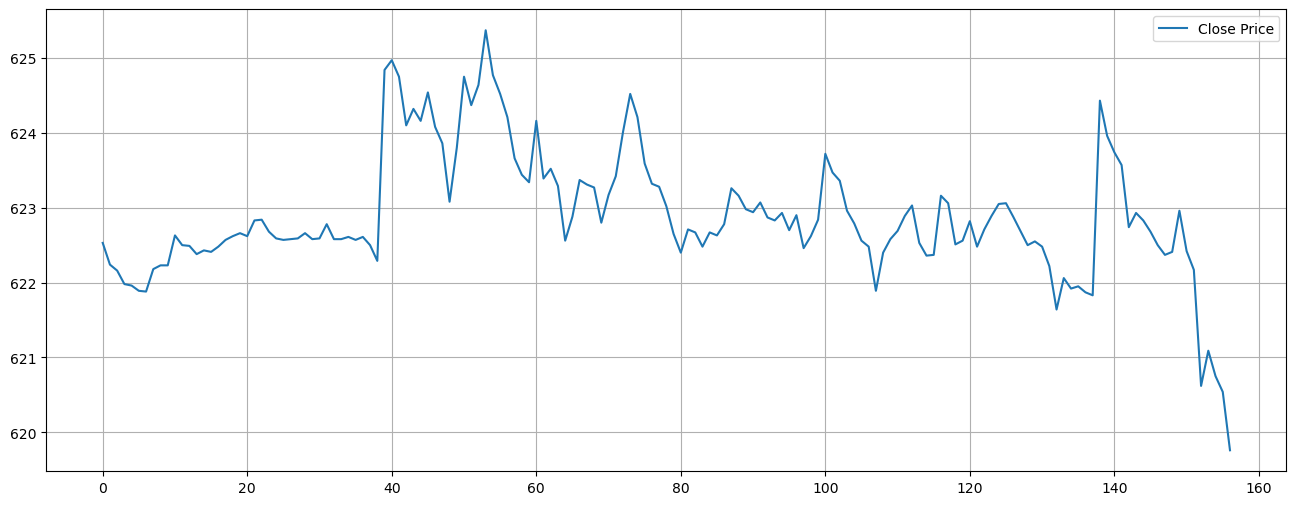

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )
plt.legend()
plt.grid(True)
plt.show()

In [25]:
df.dropna(inplace=True)

features = df[['Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR']]
target = df['Close'].shift(-1)  # Predicting the next day's closing price

scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
target_normalized = scaler.fit_transform(target.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
3/3 [==============================] - 1s 164ms/step - loss: 0.2943 - val_loss: nan
Epoch 2/50
3/3 [==============================] - 0s 39ms/step - loss: 0.1532 - val_loss: nan
Epoch 3/50
3/3 [==============================] - 0s 40ms/step - loss: 0.0753 - val_loss: nan
Epoch 4/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0379 - val_loss: nan
Epoch 5/50
3/3 [==============================] - 0s 35ms/step - loss: 0.0273 - val_loss: nan
Epoch 6/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0288 - val_loss: nan
Epoch 7/50
3/3 [==============================] - 0s 33ms/step - loss: 0.0323 - val_loss: nan
Epoch 8/50
3/3 [==============================] - 0s 34ms/step - loss: 0.0313 - val_loss: nan
Epoch 9/50
3/3 [==============================] - 0s 35ms/step - loss: 0.0262 - val_loss: nan
Epoch 10/50
3/3 [==============================] - 0s 32ms/step - loss: 0.0204 - val_loss: nan
Epoch 11/50
3/3 [==============================] - 0s 31ms

In [29]:
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

1/1 [==============================] - 0s 47ms/step - loss: 0.0054
Mean Squared Error on Test Data: 0.0053980411030352116


In [30]:
predictions = model.predict(X_test)

1/1 [==============================] - 0s 98ms/step


In [31]:
predictions_denormalized = scaler.inverse_transform(predictions)

In [32]:
mse = np.mean(np.square(predictions_denormalized - df['Close'].iloc[-len(X_test):].values))
print(f'Mean Squared Error on Test Data (Denormalized): {mse}')

Mean Squared Error on Test Data (Denormalized): 1.7369429140819537


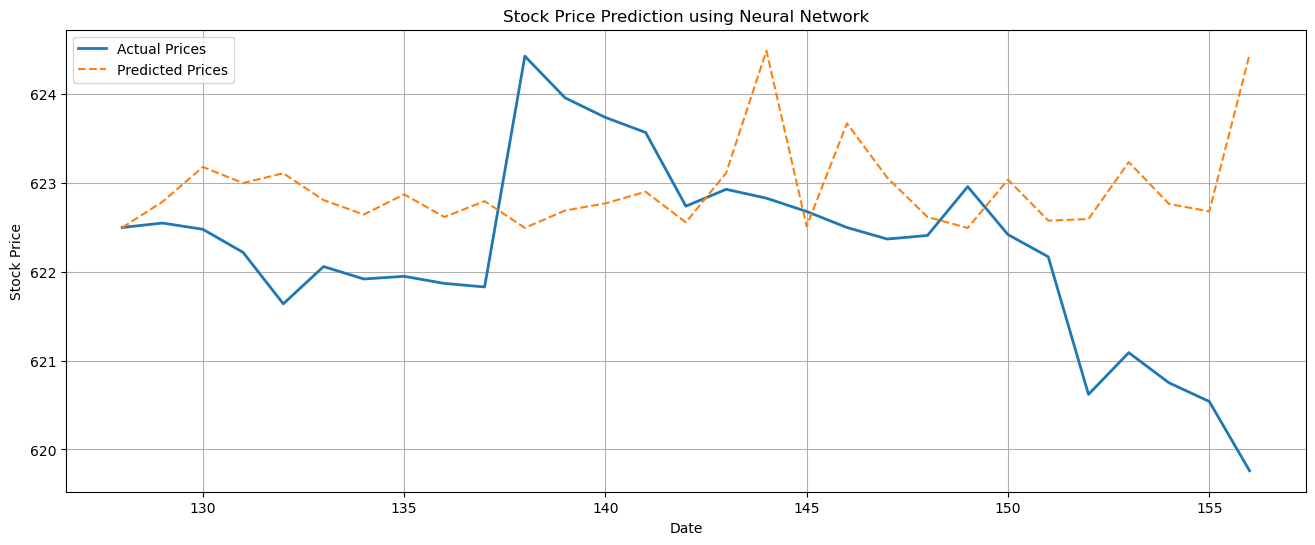

In [38]:

plt.figure(figsize=(16, 6))
plt.plot(df.index[-len(X_test):], df['Close'].iloc[-len(X_test):].values, label='Actual Prices', linewidth=2)
plt.plot(df.index[-len(X_test):], predictions_denormalized, label='Predicted Prices', linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
def train_model_until_accuracy(df, target_column='Close', accuracy_threshold=0.95, max_epochs=100):
    # Assuming you have adf with the required columns ('Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR')
    # Fill missing values or drop them
    df.dropna(inplace=True)

    # Features and target
    features = df[['Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR']]
    target = df[target_column].shift(-1)  # Predicting the next day's closing price

    # Normalize features
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)
    target_normalized = scaler.fit_transform(target.values.reshape(-1, 1))

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)

    # Build the neural network
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    epoch = 0
    while epoch < max_epochs:
        # Train the model for one epoch
        model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose=0)

        # Evaluate the model on the test set
        loss = model.evaluate(X_test, y_test, verbose=0)

        # Make predictions
        predictions = model.predict(X_test)

        # De-normalize predictions
        predictions_denormalized = scaler.inverse_transform(predictions)

        # Calculate accuracy
        accuracy = np.mean(np.square(predictions_denormalized - df[target_column].iloc[-len(X_test):].values))

        print(f'Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}')

        # Check if accuracy threshold is reached
        if accuracy >= accuracy_threshold:
            print(f'Training stopped. Desired accuracy ({accuracy_threshold * 100}%) reached.')
            break

        epoch += 1

    return model

# Example usage
trained_model = train_model_until_accuracy(df)

1/1 [==============================] - 0s 137ms/step
Epoch: 1, Loss: 0.057473890483379364, Accuracy: 1.5527377202609631
Training stopped. Desired accuracy (95.0%) reached.
